In [1]:
import pandas as pd
import numpy as np
import xgboost
import seaborn as sns
from sklearn.model_selection import ParameterGrid
import warnings
import sklearn
import shap
import matplotlib.pylab as plt
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_excel(r'C:\Users\ASUS Zephyrus G15\DATA1030-Fall2021\data 1030 project\data\전국상수도수질검사표준데이터.xls')

In [3]:
y = df['Potability']
X = df.loc[:, df.columns != 'Potability']
ftr_names = X.columns

In [9]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [5]:
file = open('../results/LR/LR4.lasso', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

In [6]:
nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])
test_score = grid.score(X_test,y_test)
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
        
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

shuffling general_bacteria
   shuffled test score: 0.775 +/- 0.007
shuffling lead
   shuffled test score: 0.777 +/- 0.0
shuffling fluoride
   shuffled test score: 0.753 +/- 0.006
shuffling arsenic
   shuffled test score: 0.776 +/- 0.002
shuffling selenium
   shuffled test score: 0.777 +/- 0.0
shuffling ammonia-like_nitrogen
   shuffled test score: 0.775 +/- 0.002
shuffling nitrogen_nitrate
   shuffled test score: 0.714 +/- 0.013
shuffling cadmium
   shuffled test score: 0.774 +/- 0.001
shuffling phenol
   shuffled test score: 0.777 +/- 0.001
shuffling diazinone
   shuffled test score: 0.776 +/- 0.001
shuffling carbaryl
   shuffled test score: 0.777 +/- 0.0
shuffling 1_1_1-trichloroethane
   shuffled test score: 0.777 +/- 0.0
shuffling tetrachloroethylene
   shuffled test score: 0.777 +/- 0.0
shuffling trichloroethylene
   shuffled test score: 0.777 +/- 0.001
shuffling carbon_tetrachloride
   shuffled test score: 0.777 +/- 0.0
shuffling 1_1-dichloroethylene
   shuffled test score: 0.771

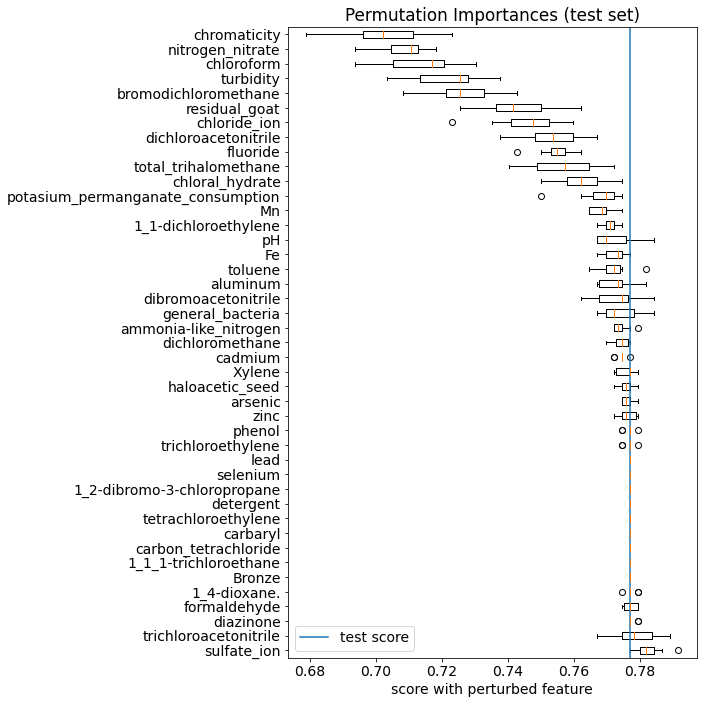

In [7]:
#plot the score difference from each features

sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,10))
plt.boxplot(scores[sorted_indcs].T,labels=(X_test.columns)[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/feature_perm_imp_logistic_regression.png')
plt.show()